In [14]:
#GENERAL
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
#PATH PROCESS
#IMAGE PROCESS
#MACHINE LEARNING
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.manifold import TSNE
from functools import partial
from sklearn.cluster import AgglomerativeClustering


1. Let's try KMeans model for images processed with AutoEncoder

In [2]:
# File paths
test_csv_path = '../data/test_data.csv'

# Load the training DataFrame
dataset = pd.read_csv(test_csv_path)

feature_extracting_dataset = dataset[['image_path', 'asset_id']]


In [3]:
actual_labels = dataset['gz2_class'].str[0]
actual_labels

0        S
1        S
2        S
3        E
4        S
        ..
71776    S
71777    S
71778    S
71779    S
71780    E
Name: gz2_class, Length: 71781, dtype: object

In [16]:
df = np.load('../data/Test_data_after_autoencoder.npy')

df = df.reshape(71781, 28 * 28)

In [17]:
scaler = StandardScaler()
df = scaler.fit_transform(df)

In [9]:
# Performing PCA to retain 90% of the variance
pca = PCA(random_state=22)
pca.fit(df)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

In [10]:
n_components_90

5

In [11]:
# Performing PCA with the determined number of components
pca = PCA(n_components=5, random_state=22)
pca.fit(df)
x = pca.transform(df)

In [18]:
# Converting the transformed features to a DataFrame
features_df = pd.DataFrame(x)

# Adding prefixes to feature column names to avoid confusion with existing columns
features_df.columns = [f'feature_{i}' for i in range(features_df.shape[1])]

# Concatenating the original dataset with the features DataFrame
combined_df = pd.concat([feature_extracting_dataset.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

In [21]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores


In [24]:
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

In [32]:
def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

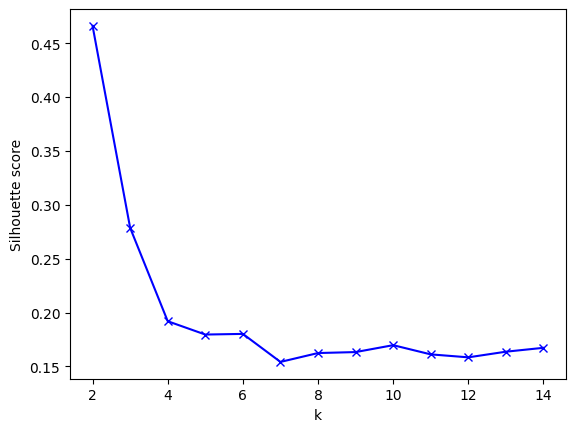

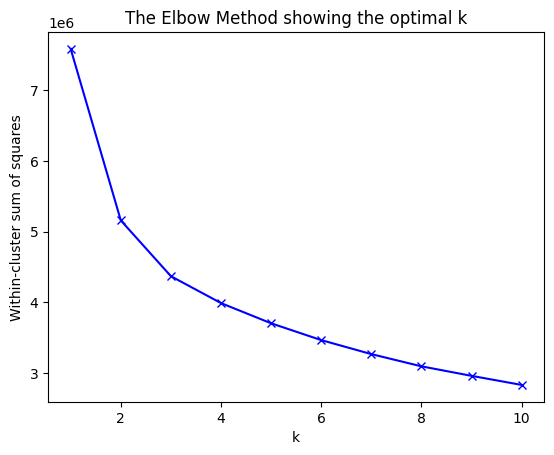

In [19]:
X = combined_df.drop(columns=['asset_id', 'image_path'])

X = X.iloc[:10000, :]

cluster_num_seq = range(2,15)
silhouette_vec = count_clustering_scores(X, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

wcss_vec = count_wcss_scores(X, 10)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

C:\Users\Mikolaj\AppData\Local\Temp\ipykernel_16468\4138897928.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:,'tsne-2d-one'] = z[:,0]
C:\Users\Mikolaj\AppData\Local\Temp\ipykernel_16468\4138897928.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:,'tsne-2d-two'] = z[:,1]


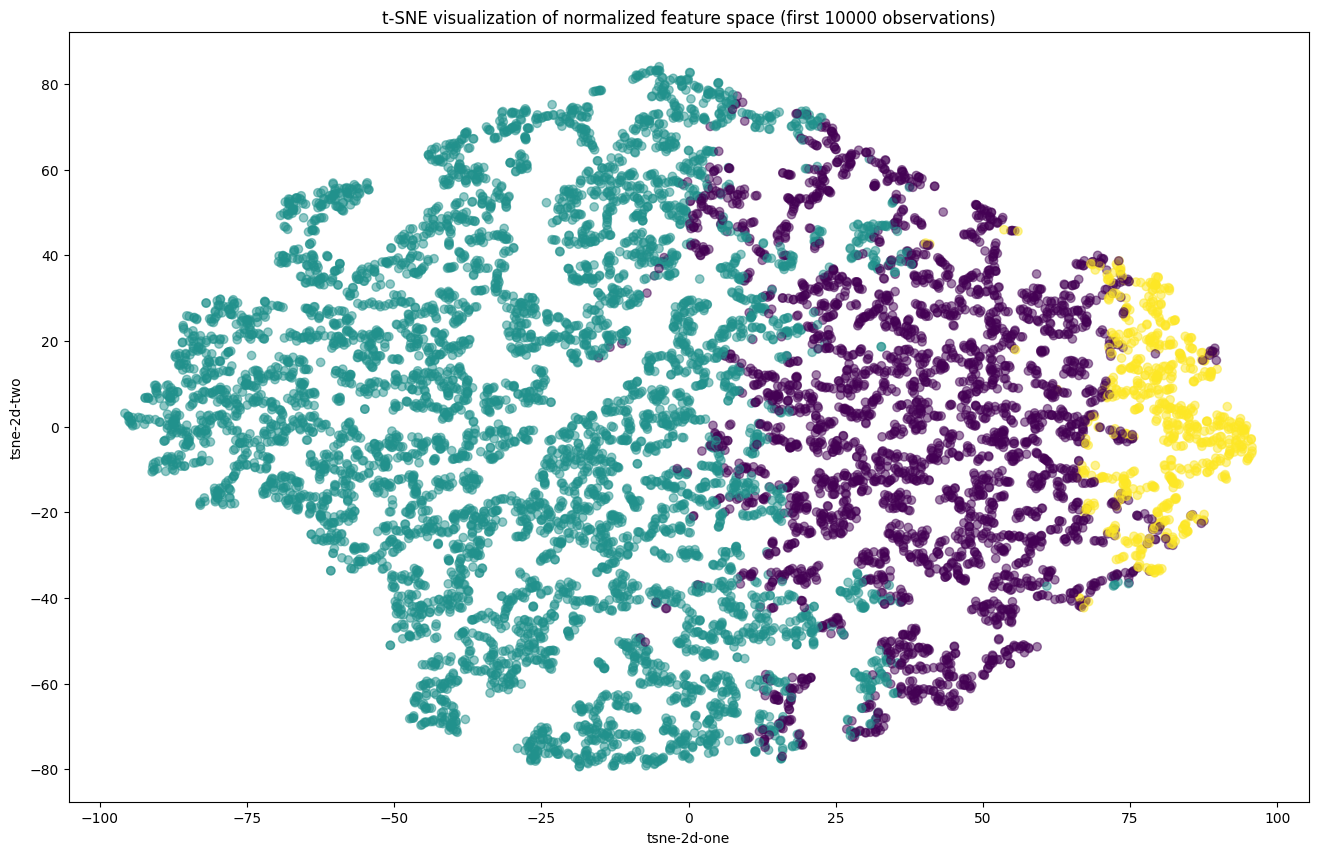

In [24]:
df = combined_df

# Select the first 10000 observations
df_subset = df.iloc[:10000, :]

# Extract feature columns
features = df_subset.iloc[:, 2:]  # Adjust if necessary to select only feature columns

# Apply t-SNE
tsne = TSNE(n_components=2, learning_rate=200)
z = tsne.fit_transform(features)

# Add t-SNE results to the DataFrame for visualization
df_subset.loc[:,'tsne-2d-one'] = z[:,0]
df_subset.loc[:,'tsne-2d-two'] = z[:,1]

model = KMeans(n_clusters = 3)
model.fit(features)
label = model.predict(features)

# Plot the result
plt.figure(figsize=(16,10))
plt.scatter(
    x=df_subset['tsne-2d-one'], 
    y=df_subset['tsne-2d-two'],
    alpha=0.5,
    c=label
)
plt.title('t-SNE visualization of normalized feature space (first 10000 observations)')
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two')
plt.show()

Now let's try KMeans for images processed with Noise Removing Model

In [6]:
df = np.load('../data/test_data_after_removing_noise.npy')

df = df.reshape(71781, 28 * 28)

In [7]:
scaler = StandardScaler()
df = scaler.fit_transform(df)

In [8]:
# Performing PCA to retain 90% of the variance
pca = PCA(random_state=22)
pca.fit(df)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

In [103]:
n_components_90

3

In [9]:
# Performing PCA with the determined number of components
pca = PCA(n_components=3, random_state=22)
pca.fit(df)
x = pca.transform(df)

In [10]:
# Converting the transformed features to a DataFrame
features_df = pd.DataFrame(x)

# Adding prefixes to feature column names to avoid confusion with existing columns
features_df.columns = [f'feature_{i}' for i in range(features_df.shape[1])]

# Concatenating the original dataset with the features DataFrame
combined_df = pd.concat([feature_extracting_dataset.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

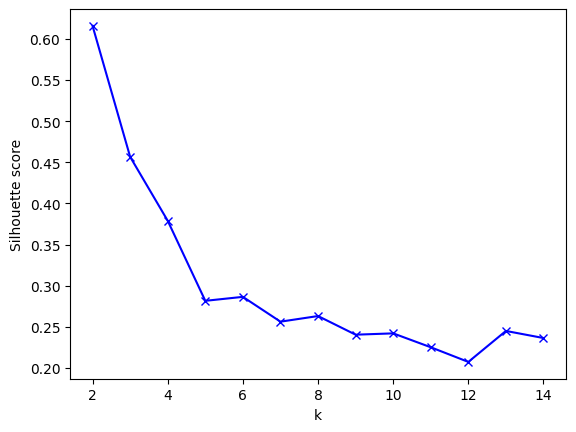

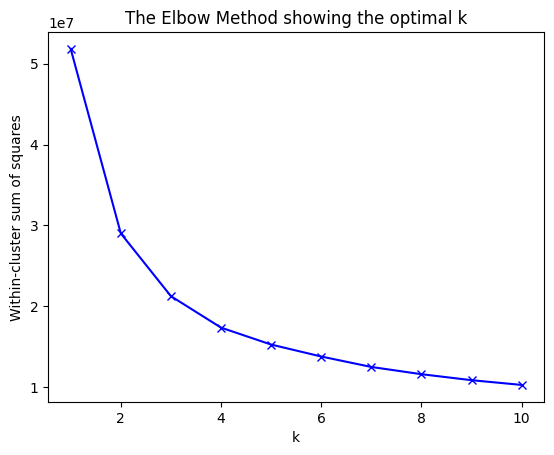

In [106]:
X = combined_df.drop(columns=['asset_id', 'image_path'])

cluster_num_seq = range(2,15)
silhouette_vec = count_clustering_scores(X, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

wcss_vec = count_wcss_scores(X, 10)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

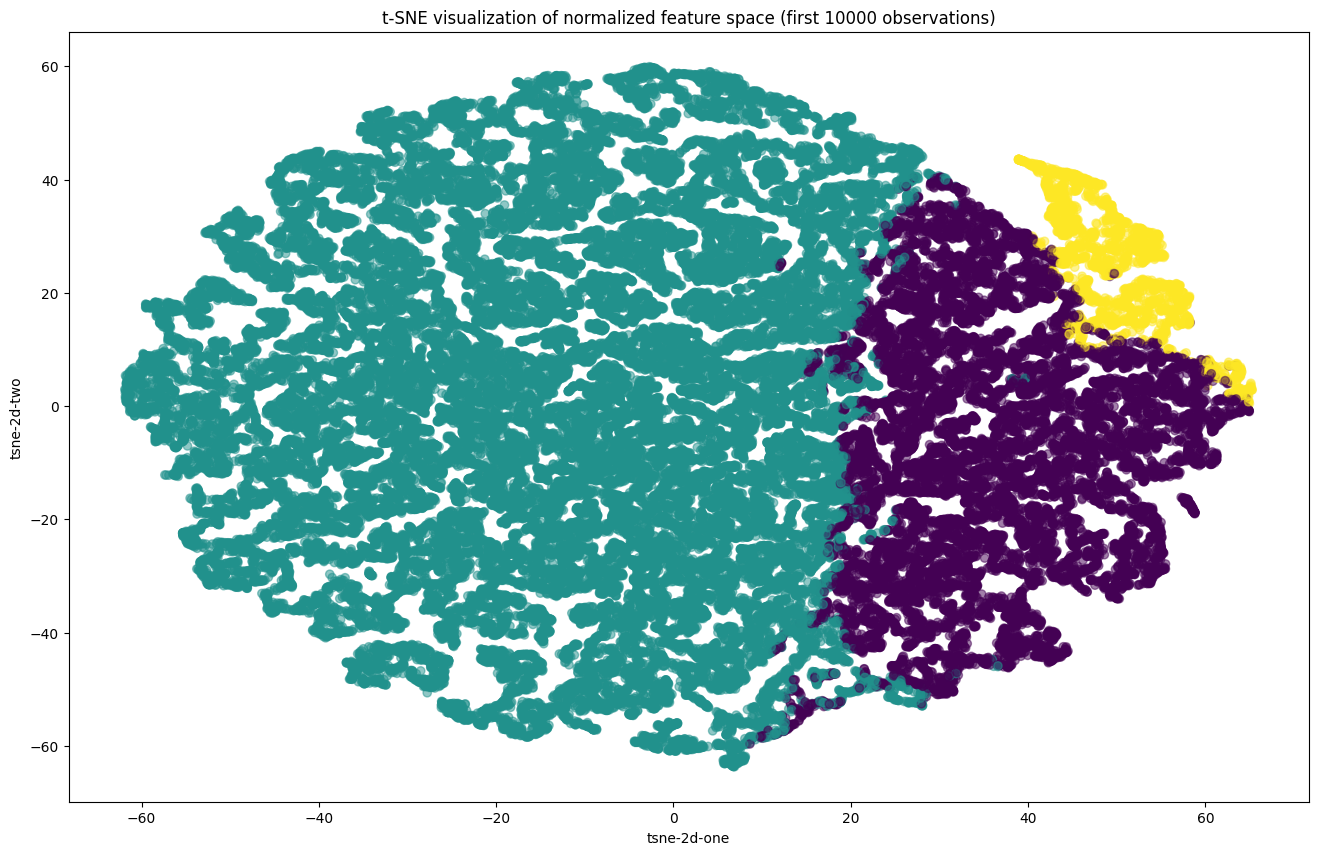

gz2_class,A,E,S
row_0,,,
0,36,6830,9768
1,127,21635,31133
2,5,907,1340


In [14]:
df = combined_df

# Extract feature columns
features = df.iloc[:, 2:]  # Adjust if necessary to select only feature columns

# Apply t-SNE
tsne = TSNE(n_components=2, learning_rate=200)
z = tsne.fit_transform(features)

# Add t-SNE results to the DataFrame for visualization
df.loc[:,'tsne-2d-one'] = z[:,0]
df.loc[:,'tsne-2d-two'] = z[:,1]

model = KMeans(n_clusters = 3)
model.fit(features)
label = model.predict(features)

# Plot the result
plt.figure(figsize=(16,10))
plt.scatter(
    x=df['tsne-2d-one'], 
    y=df['tsne-2d-two'],
    alpha=0.5,
    c=label
)
plt.title('t-SNE visualization of normalized feature space (first 10000 observations)')
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two')
plt.show()

pd.crosstab(label, actual_labels)

In [44]:
df = combined_df

# Extract feature columns
features = df.iloc[:, 2:]  # Adjust if necessary to select only feature columns

model = AgglomerativeClustering(linkage='single', n_clusters=3)
label = model.fit_predict(features)


pd.crosstab(label, actual_labels)


gz2_class,A,E,S
row_0,,,
0,168,29365,42235
1,0,1,1
2,0,6,5


In [45]:
X = combined_df.drop(columns=['asset_id', 'image_path'])


metrices = {
            'silhouette': silhouette_score
           }

models = {
          'Agglomerative ward linkage': partial(AgglomerativeClustering, linkage='ward'),
          'Agglomerative complete linkage': partial(AgglomerativeClustering, linkage='complete'),
          'Agglomerative average linkage': partial(AgglomerativeClustering, linkage='average'),
          'Agglomerative single linkage': partial(AgglomerativeClustering, linkage='single'),
          'Kmeans': KMeans
         }

df = pd.DataFrame(index=models.keys(), columns=metrices.keys())

for model_key in models:
    for metric_key in metrices:
        try:
            # Compute the score
            score = count_clustering_scores(X=X, cluster_num=3, model=models[model_key], score_fun=metrices[metric_key])
            # Assign the score to the DataFrame
            df.loc[model_key, metric_key] = score
        except Exception as e:
            print(f"Error processing {model_key} with {metric_key}: {e}")

Error processing Agglomerative ward linkage with silhouette: Unable to allocate 19.2 GiB for an array with shape (2576220090,) and data type float64
Error processing Agglomerative complete linkage with silhouette: Unable to allocate 19.2 GiB for an array with shape (2576220090,) and data type float64
Error processing Agglomerative average linkage with silhouette: Unable to allocate 19.2 GiB for an array with shape (2576220090,) and data type float64


In [46]:
df

,silhouette
Agglomerative ward linkage,NaN
Agglomerative complete linkage,NaN
Agglomerative average linkage,NaN
Agglomerative single linkage,0.912596
Kmeans,0.45676


This version seems to be the most promising so far. Let's look closer at these photos

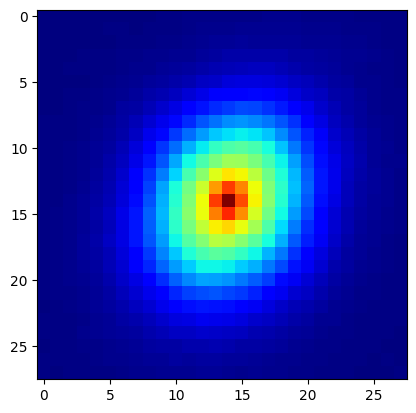

In [59]:
Removing_N_IMG = np.load('../data/test_data_after_removing_noise.npy')

plt.imshow(Removing_N_IMG[6000], cmap = 'jet')
plt.show()

In [60]:
df = Removing_N_IMG.reshape(71781, 28 * 28)
normalizer = Normalizer()
df = normalizer.fit_transform(df)


In [52]:
scaler = StandardScaler()
df = scaler.fit_transform(df)

In [53]:
# Performing PCA to retain 90% of the variance
pca = PCA(random_state=22)
pca.fit(df)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

In [54]:
n_components_90

4

In [55]:
# Performing PCA with the determined number of components
pca = PCA(n_components=4, random_state=22)
pca.fit(df)
x = pca.transform(df)

In [61]:

# Converting the transformed features to a DataFrame
features_df = pd.DataFrame(x)

# Adding prefixes to feature column names to avoid confusion with existing columns
features_df.columns = [f'feature_{i}' for i in range(features_df.shape[1])]

# Concatenating the original dataset with the features DataFrame
combined_df = pd.concat([feature_extracting_dataset.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

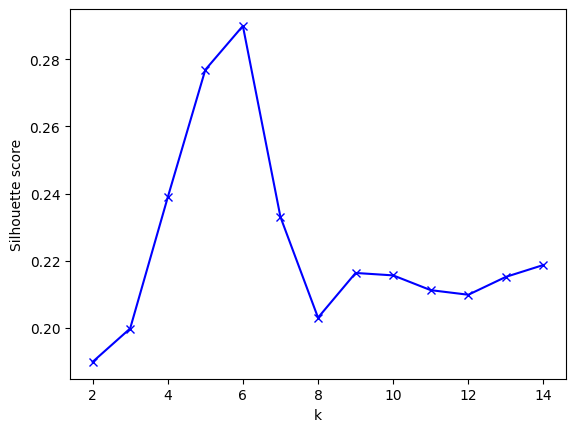

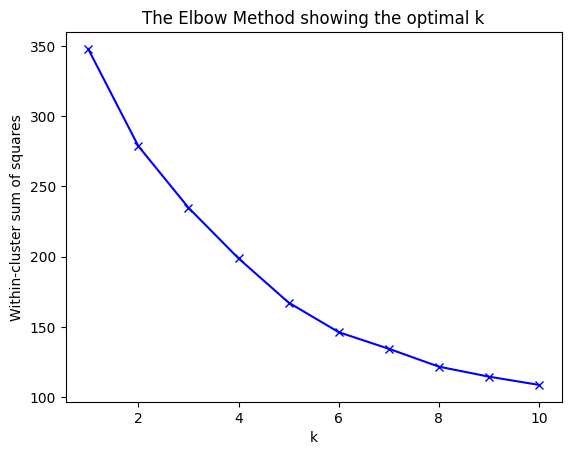

In [62]:
X = combined_df.drop(columns=['asset_id', 'image_path'])

X = X.iloc[:10000, :]

cluster_num_seq = range(2,15)
silhouette_vec = count_clustering_scores(X, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

wcss_vec = count_wcss_scores(X, 10)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

C:\Users\Mikolaj\AppData\Local\Temp\ipykernel_16468\4138897928.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:,'tsne-2d-one'] = z[:,0]
C:\Users\Mikolaj\AppData\Local\Temp\ipykernel_16468\4138897928.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:,'tsne-2d-two'] = z[:,1]


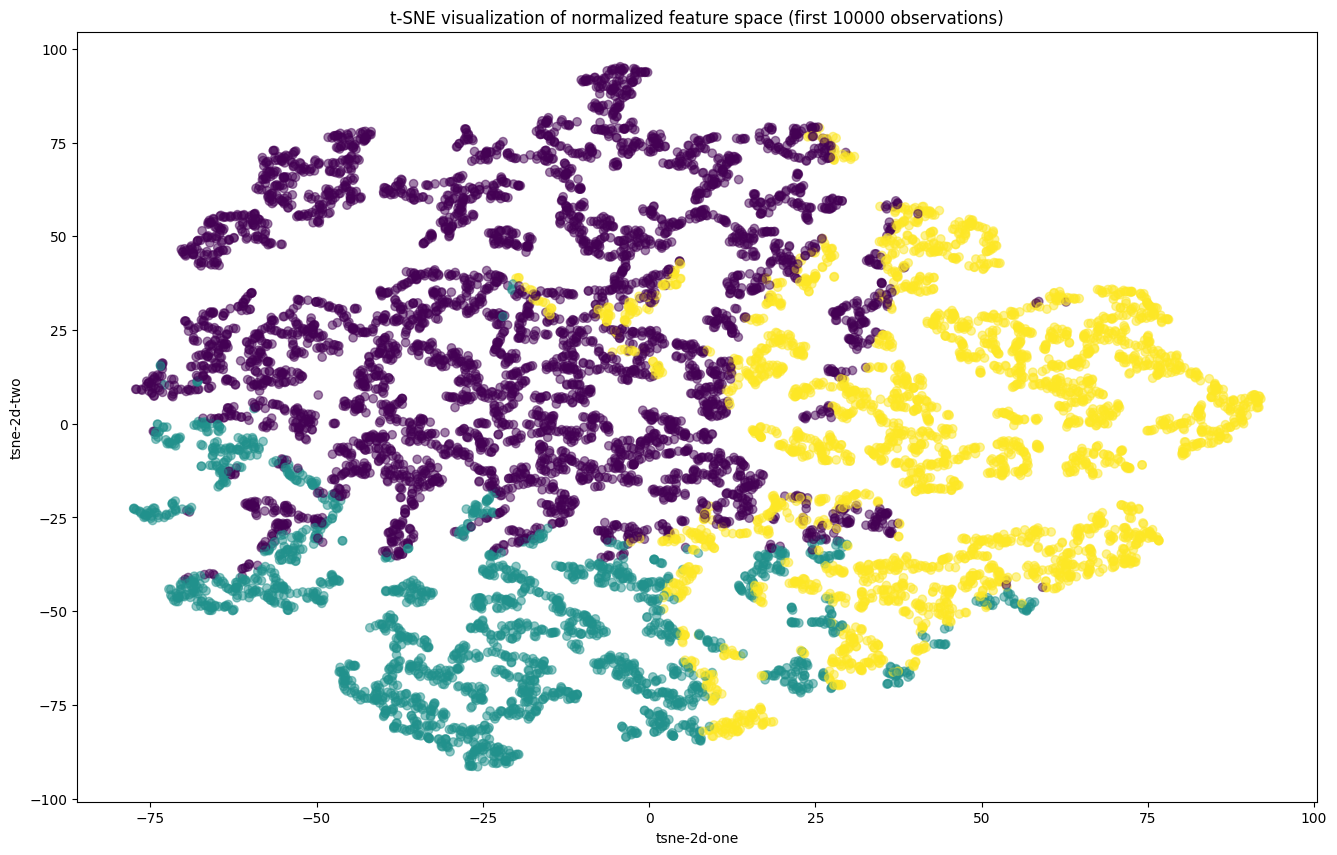

In [63]:
df = combined_df

# Select the first 10000 observations
df_subset = df.iloc[:10000, :]

# Extract feature columns
features = df_subset.iloc[:, 2:]  # Adjust if necessary to select only feature columns

# Apply t-SNE
tsne = TSNE(n_components=2, learning_rate=200)
z = tsne.fit_transform(features)

# Add t-SNE results to the DataFrame for visualization
df_subset.loc[:,'tsne-2d-one'] = z[:,0]
df_subset.loc[:,'tsne-2d-two'] = z[:,1]

model = KMeans(n_clusters = 3)
model.fit(features)
label = model.predict(features)

# Plot the result
plt.figure(figsize=(16,10))
plt.scatter(
    x=df_subset['tsne-2d-one'], 
    y=df_subset['tsne-2d-two'],
    alpha=0.5,
    c=label
)
plt.title('t-SNE visualization of normalized feature space (first 10000 observations)')
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two')
plt.show()

pd.crosstab(label, actual_labels)